# Bayesian Linear Regression



This project focuses on implementing some of the requisite calculations and manipulations for applying Bayesian linear regression models. This includes:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculating error-bars (the predictive variance), and,
- presentation of results.

The data will be derived from a synthetic, noisy, sine wave and our model will be a linearly-weighted set of "Gaussian" (RBF) basis functions. A modification has been made to the data: there are no observations from one particular region of the data space. One of the aims of the project is to see how this aspect impacts on the uncertainty of the model predictions.

There are 3 principal tasks (detailed below). In summary here:

1. Fit various Gaussian RBF-based linear models to the training data using penalised least-squares, and visualise the results ,
2. Compute the train, validation and test set errors, plus the marginal likelihood, over a range of $\lambda$ (or $\alpha$) values ,
3. Identify the best posterior mean model, visualise it along with its error-bars (predictive variance), and consider how those error-bars might be usefully exploited .


## Setup




In [1]:
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
# Lab-specific support module
import cm50268_lab1_setup as lab1
#
N_train = 12
N_val   = N_train
N_test  = 250
#
sigma = 0.1
s2    = sigma**2


### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=12$ with added noise $\sigma=0.1$
- validation set of size $N_{val}=12$ with added noise $\sigma=0.1$
- test set of size $N_{test}=250$ with **no noise** and which **covers the full $x$-space**

**Note:** we assume throughtout that $\sigma$ is known and fixed. A feature of the test set here is that *it will include data from a region where there is no training data*.

### Generate Basis
For our linear model, we use as many functions as data points (a "complete" basis), comprising $N-1$ equally-spaced Gaussian functions (of width 1), plus a fixed "bias" or "offset". If we call `evaluate` on the basis generator, we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains the output of each basis function on each data point respectively: that is, $\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains simply a fixed value of one. 

For the training and validation set, this matrix $\mathbf{\Phi}$ will be $12\times 12$, whereas for the test set it will be $250 \times 12$.



In [2]:
# Data - create generator instance, and synthesise 3 sets
#
generator = lab1.DataGenerator(noise=sigma)
#
(x_train, t_train) = generator.get_data('TRAIN', N_train)
(x_val, t_val) = generator.get_data('VALIDATION', N_val)
(x_test, t_test) = generator.get_data('TEST', N_test)

# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
M = N_train-1
r = 1 # Basis radius or width
centres = np.linspace(generator.xmin, generator.xmax, M)
basis = lab1.RBFGenerator(centres, width=r, bias=True)
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)


## Task 1a 

A function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `t_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

The ideal solution will treat the $\lambda=0$ case differently to $\lambda>0$.


In [3]:
## FIT_PLS
##
def fit_pls(PHI, t, lam):
    #
    #
    PHI_t = np.transpose(PHI)
    lambda_identity = lam*np.identity(len(PHI_t))
    theInverse = np.linalg.inv(np.dot(PHI_t, PHI)+lambda_identity)
    w = np.dot(np.dot(theInverse, PHI_t), t)
    
    return w


## Task 1b

First, write a convenient graphing function `plot_regression` that you will need for this and following tasks. It should be capable of being passed suitable arguments to plot on the same axes:

- the data (*i.e.* `t_train` above),
- the generating function (*i.e.* the noise-free `t_test` above),
- some approximating function, or predictor, $y$ (you will compute some shortly).

Using `fit_pls` in conjunction with `plot_regression`, add code below to plot three graphs for values of $\lambda$ in \[ 0, 0.01, 10\]. In each graph (appropriately labelled by $\lambda$), show:

1. the training data (`x_train` / `t_train`)
2. the underlying generating function (by plotting `x_test` / `t_test`)
3. your fitted function at points `x_test` (you will need to multiply the relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)



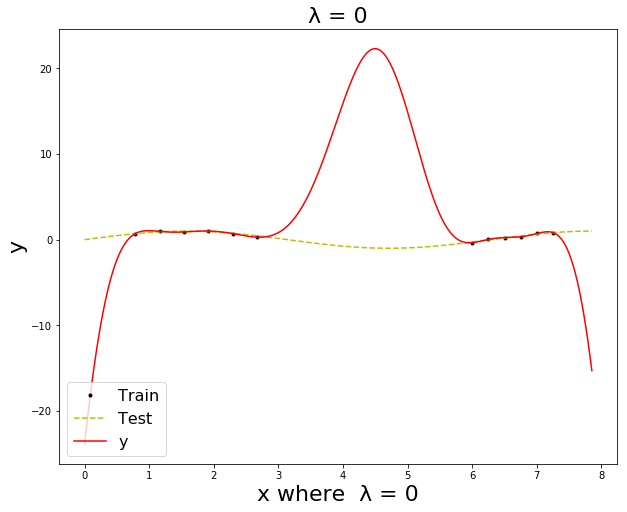

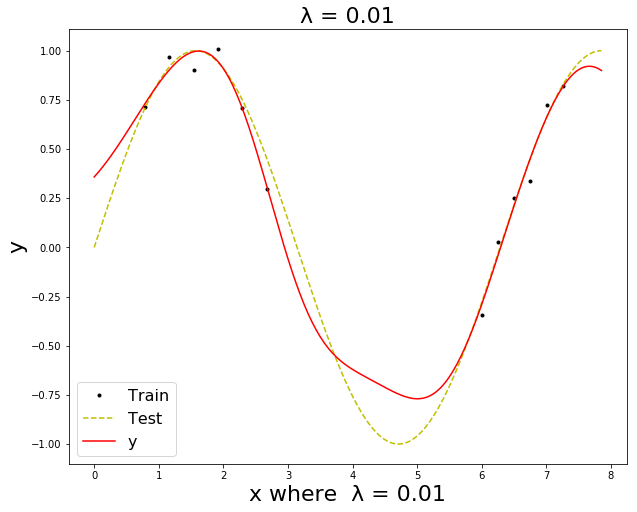

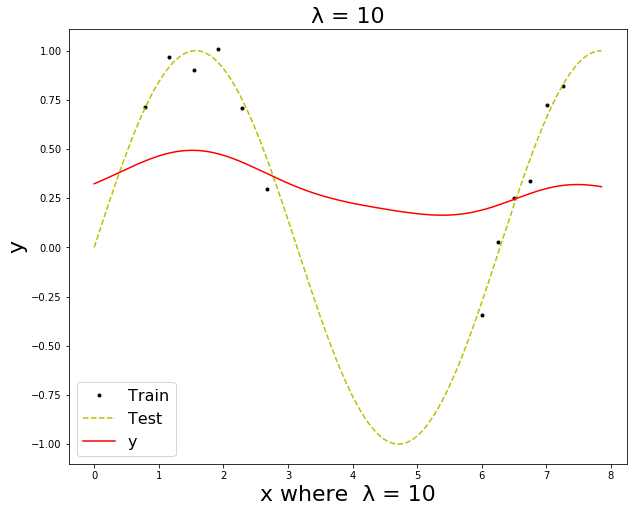

In [4]:
#### **** YOUR CODE HERE **** ####    

def plot_regression(t_train, t_test, y, y_label):
    
    plt.figure(figsize=(10, 8))
    plt.plot(x_train,t_train,'k.', label='Train')
    plt.plot(x_test,t_test,'y--', label='Test')
    plt.plot(x_test,y,'r-', label=y_label)
    
    
    
lambdas = [0, 0.01, 10]
for lam in lambdas:
    w = fit_pls(PHI_train, t_train, lam)
    y = np.dot(PHI_test,w)
    plot_regression(t_train, t_test, y, 'y')
    
    plt.xlabel('x where  λ = ' + str(lam), fontsize=22)
    plt.ylabel('y', fontsize=22)
    plt.title('λ = '+ str(lam), fontsize=22)
    plt.legend(loc='lower left', fontsize=16)
    plt.show()

## Task 2a

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

Verify the consistency of your posterior code with `fit_pls` by comparing the outputs `w` and `Mu` (they should be the same, remembering that for equivalence, $\alpha = \lambda/\sigma^2$). As well as defining your function below, append a few lines of code underneath which show your consistency check for $\lambda=0.01$.


In [5]:
## POSTERIOR

## Using 𝝁 = (𝚽ᵀ𝚽 + 𝜎²𝛼𝐈)⁻¹𝚽ᵀ
## and   𝚺 = 𝜎²(𝚽ᵀ𝚽 + 𝜎²𝛼𝐈)⁻¹

##
def compute_posterior(PHI, t, alph, s2):
    
    PHI_t = np.transpose(PHI)
    s2alpha_identity = s2*alph*np.identity(len(PHI_t))
    theInverse = np.linalg.inv(np.dot(PHI_t, PHI)+s2alpha_identity)
    
    Mu = np.dot(np.dot(theInverse, PHI_t), t)
    
    SIGMA = s2*theInverse
    
    return Mu, SIGMA

gamma = 0.01
alph = gamma/s2
compute_posterior(PHI_train, t_train, alph, s2)


(array([[ 0.17542751],
        [-0.00686358],
        [ 0.27718726],
        [ 0.4473822 ],
        [ 0.49475058],
        [-0.47860652],
        [-0.30393321],
        [-0.3891278 ],
        [-0.60869482],
        [-0.02742655],
        [ 0.28990501],
        [ 0.5720677 ]]),
 array([[ 0.32226847, -0.1195789 , -0.17744102, -0.11713427, -0.15639906,
         -0.15718633, -0.05173313, -0.05640968, -0.17237852, -0.13245783,
         -0.14368281, -0.17179645],
        [-0.1195789 ,  0.48273878, -0.23669577,  0.22090308, -0.04538475,
          0.10629305,  0.05824881,  0.02362181,  0.06219257,  0.04959204,
          0.0533998 ,  0.06345621],
        [-0.17744102, -0.23669577,  0.34671003, -0.1147483 ,  0.21528027,
          0.00686953, -0.00126513,  0.02980521,  0.09605513,  0.07261807,
          0.07907462,  0.09476837],
        [-0.11713427,  0.22090308, -0.1147483 ,  0.21081804, -0.09546772,
          0.17499815,  0.02532207,  0.01911512,  0.06282451,  0.04816414,
          0.05217312, 

## Task 2b

A function `compute_log_marginal` to compute the *logarithm* of the marginal likelihood for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.



In [6]:
## MARGINAL LIKELIHOOD

## Using 𝑝(𝐭|𝛼, 𝜎²) = (2𝜋)⁻ᴺ/² |𝜎²𝐈 + 𝛼⁻¹𝚽𝚽ᵀ|⁻¹/² exp {−1/2𝐭ᵀ(𝜎²𝐈 + 𝛼⁻¹𝚽𝚽ᵀ)⁻¹𝐭}
## where t = 𝜎²𝐈 + 𝛼⁻¹𝚽𝚽ᵀ

##
def compute_log_marginal(PHI, t, alph, s2):
    
    # t covariance matrix
    PHI_t = np.transpose(PHI)
    alph_inv = 1/alph
    s2_identity = s2*np.identity(len(PHI_t))
    cov = s2_identity + alph_inv*np.dot(PHI_t, PHI)
    
    # exponential portion
    cov_inverse = np.linalg.inv(cov)
    t_transpose = np.transpose(t)
    expon_portion = np.exp(-0.5*np.dot(np.dot(t_transpose, cov_inverse),t))
    
    # determinant portion
    det_portion = math.pow(np.linalg.det(cov),-0.5)
    
    #pi portion
    N = 12
    pi_portion = math.pow(2*np.pi, -1*N/2)
    
    lgp = -1*np.log(pi_portion*np.dot(det_portion, expon_portion)) 
    
    return lgp

compute_log_marginal(PHI_train, t_train, alph, s2)



array([[79.18192064]])

# Task 2c

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, should:

- Compute the train, validation and test set errors for the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms` to calculate the error). 
- Also compute the *negative* log marginal likelihood, using the function just written.
- Plot all these curves on the same graph, noting that the scale for the errors is different for that of the negative log marginal likelihood.


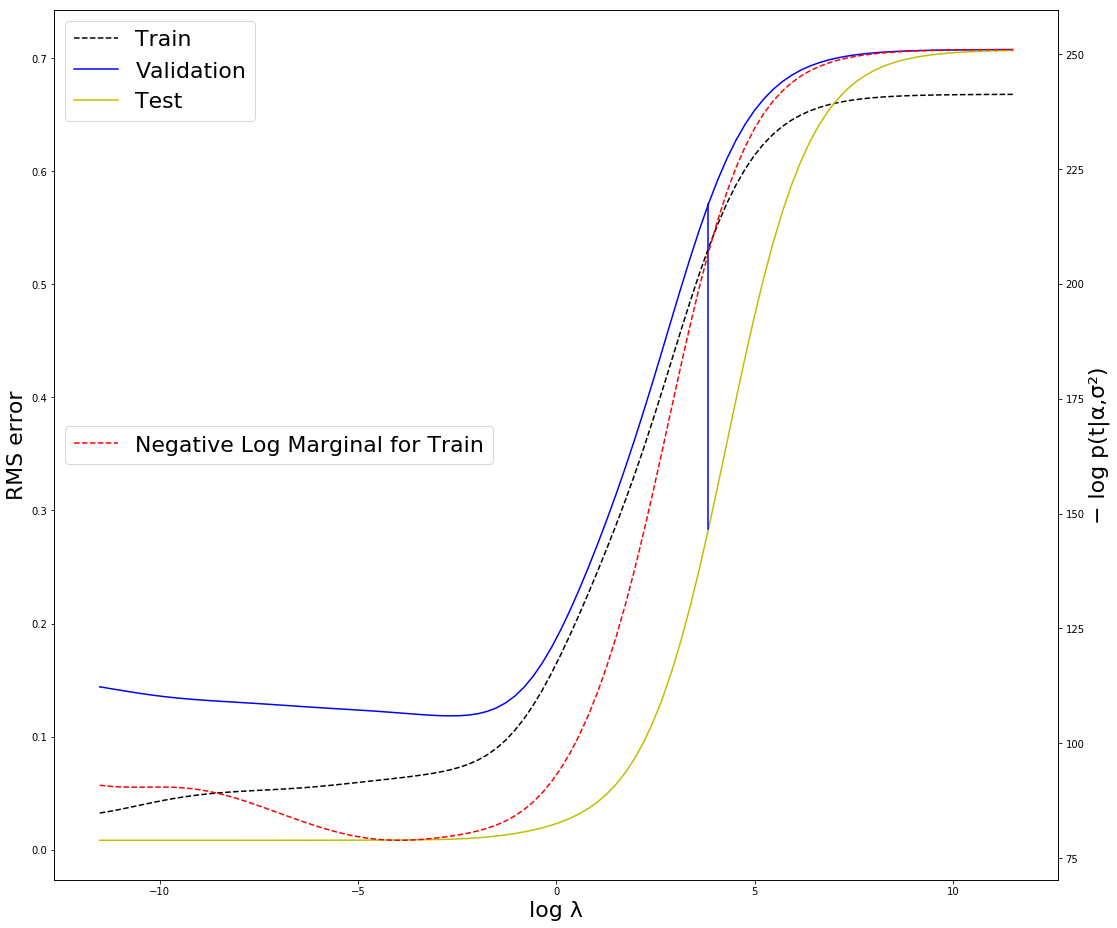

Minimum value of Negative Log Marginal :  78.89689134406166
Best Alpha value :  1.7073526474706902


In [7]:
#### **** YOUR CODE HERE **** ####

begin = -5
end = 5
steps = 100
v = np.linspace(begin,end,steps)
lambdas = 10**v

err_train = np.zeros(len(lambdas))
err_val = np.zeros(len(lambdas))
err_test = np.zeros(len(lambdas))
lg_marg = np.zeros(len(lambdas))
l = 0

for lam in lambdas:
    w_train = fit_pls(PHI_train, t_train, lam)
    y_train = np.dot(PHI_train,w_train)
    err_train[l] = lab1.error_rms(t_train, y_train)
    
    y_val = np.dot(PHI_val,w_train)
    err_val[l] = lab1.error_rms(t_val, y_val)
    
    w_test = fit_pls(PHI_test, t_test, lam)
    y_test = np.dot(PHI_test,w_test)
    err_test[l] = lab1.error_rms(t_test, y_test)
    
    alpha = lam/s2
    lg_marg[l] = compute_log_marginal(PHI_train, t_train, alpha, s2)
    l += 1

    
val_test_bar = [err_val[66],err_test[66]]
x_val_test_bar = [np.log(lambdas[66]), np.log(lambdas[66])]

plt.figure(figsize=(18, 16))
plt.plot(np.log(lambdas),err_train,'k--', label='Train')
plt.plot(np.log(lambdas),err_val,'b', label='Validation')
plt.plot(np.log(lambdas),err_test,'y', label='Test')
plt.plot(x_val_test_bar, val_test_bar, 'b')
plt.legend(loc='upper left', fontsize=22)
plt.ylabel('RMS error', fontsize=22)
plt.xlabel('log λ', fontsize=22)

plt.gca().twinx()
plt.plot(np.log(lambdas),lg_marg,'r--', label='Negative Log Marginal for Train')
plt.legend(loc='center left', fontsize=22)
plt.ylabel('− log p(t|α,σ²)', fontsize=22)
plt.show()


min_lg_marg = min(lg_marg)
print('Minimum value of Negative Log Marginal : ',min_lg_marg)
best_lam = lambdas[np.argmin(lg_marg)]
best_alpha = lambdas[np.argmin(lg_marg)]/s2
print('Best Alpha value : ',best_alpha)


# Task 2d


We find the best value of $\alpha$ according to the marginal likelihood in Task 2c above, call `compute_posterior` to find the posterior mean weight vector `Mu` and use this to compute the posterior mean predictor (*i.e.* $y=\Phi\mu$) at all the test points `x_test`. Then, similar to Task 1b, using your earlier `plot_regression` function, plot on the same axes:
1. the training data (`x_train` / `t_train`),
2. the underlying generating function (by plotting `x_test` and `t_test`),
3. the posterior mean predictor function you just calculated.


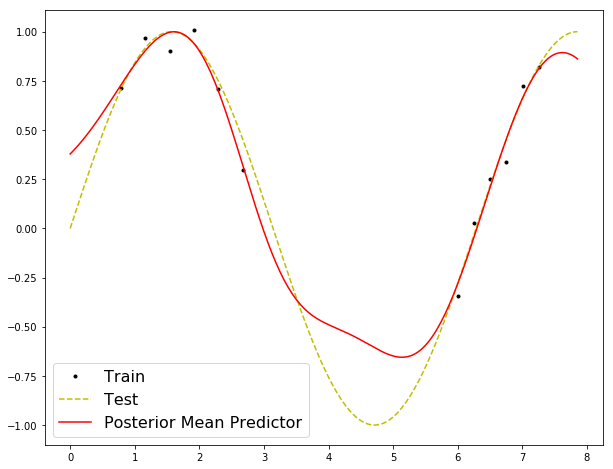

In [8]:


MU,SIGMA = compute_posterior(PHI_train, t_train, best_alpha, s2)
posterior_mean_predictor = np.dot(PHI_test,MU)

plot_regression(t_train, t_test, posterior_mean_predictor, 'Posterior Mean Predictor')

plt.legend(loc='lower left', fontsize=16)
plt.show()





# Task 3a

We repeat the graph above (Task 2d), for the same "best" predictor, but this time also compute the predictive variance at the points `x_test` and add them to the same plot as "error bars".



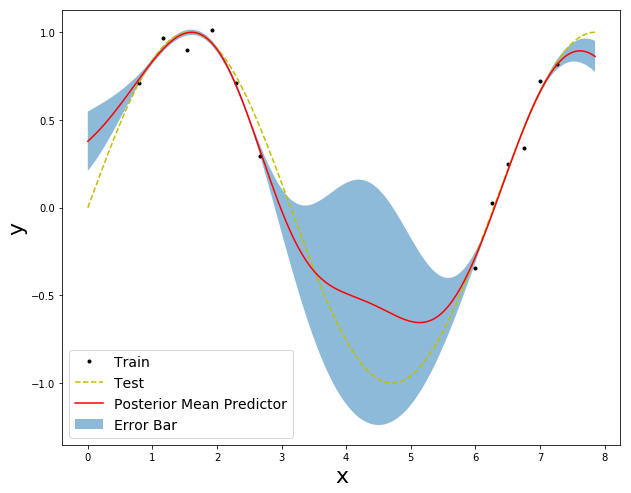

In [9]:
## Using 𝜎²*= 𝜎²ᴹᴾ + 𝛟(𝑥*)ᵀ𝚺 𝛟(𝑥*)


plot_regression(t_train, t_test, posterior_mean_predictor, 'Posterior Mean Predictor')

s2_star = s2 + PHI_test @(SIGMA @np.transpose(PHI_test)) 
i_max = np.zeros(len(s2_star[0]))


max_s2_star = s2_star.max(1)     

upper_limit = np.transpose(posterior_mean_predictor)[0] + max_s2_star

lower_limit = np.transpose(posterior_mean_predictor)[0] - max_s2_star

plt.fill_between(np.transpose(x_test)[0], upper_limit, lower_limit, alpha=0.5, label='Error Bar')

plt.legend(loc='lower left', fontsize=14)
plt.xlabel('x', fontsize=22)
plt.ylabel('y', fontsize=22)
plt.show()
